# Validation Analysis - Figures

In [3]:
SAVE_FIGS = True

In [1]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
REPO_ROOT = '/Users/rwegener/repos/chesapeake_mhw'

In [4]:
# MUR and Geopolar anomaly compared to in situ anomaly
# wq_sst = pd.read_csv('../data/AllTemps_SSTAnomaly.csv')
# 'Anomaly_values_satellite_cbp.csv'
path = os.path.join(REPO_ROOT, 'data/processed', 'raw_values_satellites_CBPstations_filtered.csv')
wq_sst = pd.read_csv(path, parse_dates=[3])

### delete later

In [6]:
june = wq_sst[(wq_sst.SampleDate.dt.month == 5)]

In [7]:
june.columns

Index(['MeasureValue', 'Latitude', 'Longitude', 'SampleDate', 'geopolar',
       'mur'],
      dtype='object')

In [8]:
from scipy.stats import norm
import matplotlib.pyplot as plt

In [9]:
t_mean = june.MeasureAnomaly.mean()
t_std = june.MeasureAnomaly.std()
print(t_mean, t_std)

AttributeError: 'DataFrame' object has no attribute 'MeasureAnomaly'

In [ ]:
gp_mean = june.geopolar_anom.mean()
gp_std = june.geopolar_anom.std()
print(gp_mean, gp_std)

In [ ]:
june.geopolar_anom.max(), june.geopolar_anom.min()

In [ ]:
x = np.arange(-5, 5, 0.05)

plt.plot(x, norm.pdf(x, gp_mean, gp_std)) 
plt.vlines(gp_mean, 0, 0.26)
plt.plot(x, norm.pdf(x, t_mean, t_std)) 
plt.vlines(t_mean, 0, 0.24, color='orange')

In [ ]:
wq_sst.groupby(wq_sst.SampleDate.dt.month)['geopolar_anom'].mean()

In [ ]:
june.MeasureAnomaly.hist(bins=45)

## Computing $R^2$ and creating scatter plot

### Preprocessing and $R^2$

In [5]:
mur_nonan = wq_sst[~wq_sst['mur'].isnull()]
geop_nonan = wq_sst[~wq_sst['geopolar'].isnull()]

In [6]:
# geop_nonan = geop_nonan[(geop_nonan.MeasureAnomaly > -5) & (geop_nonan.MeasureAnomaly < 5)]

In [7]:
x_geop = geop_nonan.MeasureValue
y_geop = geop_nonan.geopolar

x_mur = mur_nonan.MeasureValue
y_mur = mur_nonan.mur

In [8]:
mur_slope, mur_intercept, r_value, p_value, std_err = scipy.stats.linregress(x_mur, y_mur)

print('MUR: slope', mur_slope, 'intercept', mur_intercept, 'r squared', r_value**2, 'p_value', p_value)

MUR: slope 0.9729869587916135 intercept 0.10951442086025054 r squared 0.9536011607260125 p_value 0.0


In [9]:
gp_slope, gp_intercept, r_value, p_value, std_err = scipy.stats.linregress(x_geop, y_geop)

print('GEOPOLAR: slope', gp_slope, 'intercept', gp_intercept, 'r squared', r_value**2, 'p_value', p_value)

GEOPOLAR: slope 0.9599732210393214 intercept 0.37815521328222346 r squared 0.9647551801260794 p_value 0.0


In [10]:
xmin, xmax = pd.concat([x_geop, x_mur]).min(), pd.concat([x_geop, x_mur]).max()
ymin, ymax = pd.concat([y_geop, y_mur]).min(), pd.concat([y_geop, y_mur]).max()
print(xmin, xmax, ymin, ymax)

-0.8 32.2 -1.649993896484375 31.11700439453125


#### Moving away from OLS

[https://www.statsmodels.org/stable/rlm.html](https://www.statsmodels.org/stable/rlm.html)

References:
- SO [example](https://stackoverflow.com/questions/46606082/using-huber-scale-and-location-estimator-in-statsmodel)
- Penn State [course webpage](https://online.stat.psu.edu/stat501/lesson/t/t.1/t.1.1-robust-regression-methods)
- statsmodels [RLMdocs](https://www.statsmodels.org/stable/generated/statsmodels.robust.robust_linear_model.RLM.html)
- [graphs](https://www.statsmodels.org/stable/rlm_techn1.html) for the weight function
- SO [post](https://stackoverflow.com/questions/31655196/how-to-get-r-squared-for-robust-regression-rlm-in-statsmodels) arguing against R2 when using robust regression

In [11]:
import statsmodels.api as sm

In [12]:
res = sm.OLS(y_mur, x_mur).fit()
print(res.params)
print(res.bse)

MeasureValue    0.977932
dtype: float64
MeasureValue    0.000504
dtype: float64


In [13]:
# scipy.stats.linregress(x_mur, y_mur)

mur_model = sm.RLM(y_mur, sm.add_constant(x_mur), M=sm.robust.norms.TukeyBiweight())
mur_results = mur_model.fit()
print(mur_results.params)  # I think this is the slope
print(mur_results.bse)

const           0.295069
MeasureValue    0.981655
dtype: float64
const           0.016509
MeasureValue    0.000815
dtype: float64


In [14]:
rlm_slope_mur = mur_results.params.MeasureValue
rlm_inter_mur = mur_results.params.const

In [15]:
rlm_slope_mur

0.9816546679564828

In [16]:
rlm_inter_mur

0.2950694453621511

In [17]:
geop_model = sm.RLM(y_geop, sm.add_constant(x_geop), M=sm.robust.norms.TukeyBiweight())
geop_results = geop_model.fit()
print(geop_results.params)  # I think this is the slope
print(geop_results.bse)

const           0.299810
MeasureValue    0.974236
dtype: float64
const           0.015213
MeasureValue    0.000746
dtype: float64


In [18]:
rlm_slope_geop = geop_results.params.MeasureValue
rlm_inter_geop = geop_results.params.const

In [19]:
rlm_slope_geop

0.974235551102043

In [20]:
rlm_inter_geop

0.29980979702469834

In [21]:
geop_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               geopolar   No. Observations:                32491
Model:                            RLM   Df Residuals:                    32489
Method:                          IRLS   Df Model:                            1
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 12 Aug 2024                                         
Time:                        08:19:02                                         
No. Iterations:                    44                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2998      0.015     19.707      0.000       0.270       0.330
MeasureValue     0.9742      0.001   1305.767      0.000       0.973       0.976
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [22]:
def mx_plus_b(x, slope, intercept):
    return slope * x + intercept

Note: It is possible I am missing values on this graph because `mincnt` I believe is only showing bins where there are at least 2 values. So maybe we are dropping lots of values?

In [23]:
geop_nonan

,MeasureValue,Latitude,Longitude,SampleDate,geopolar,mur
0,8.300,38.40000,-77.32000,2007-03-22,4.149994,NaN
1,26.200,38.40000,-77.32000,2007-06-18,22.119995,NaN
2,14.500,38.40000,-77.32000,2007-10-29,18.169983,NaN
3,5.200,38.40000,-77.32000,2007-12-10,10.899994,NaN
4,4.900,38.40000,-77.32000,2008-02-04,3.820007,NaN
...,...,...,...,...,...,...
35699,29.280,37.48865,-76.74903,2008-07-22,28.339996,27.885986
35700,26.580,37.48865,-76.74903,2008-08-22,25.359985,26.261993
35701,25.190,37.48865,-76.74903,2008-09-17,24.929993,23.649994
35702,21.538,37.48865,-76.74903,2008-10-16,19.669983,21.384003


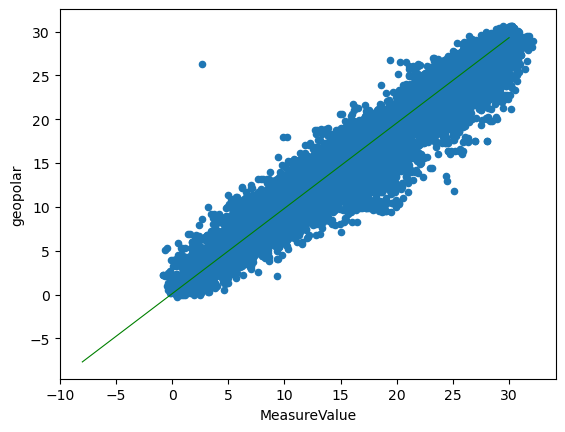

In [24]:
geop_nonan.plot.scatter('MeasureValue', 'geopolar')
# plt.plot([-10, 10], [-10, 10], color='blue', label='1:1 line', linewidth=0.8)
plt.plot([-8, 30], [mx_plus_b(-8, mur_slope, mur_intercept), 
                     mx_plus_b(30, mur_slope, mur_intercept)], 
         color='green', label='linear fit', linewidth=0.8)

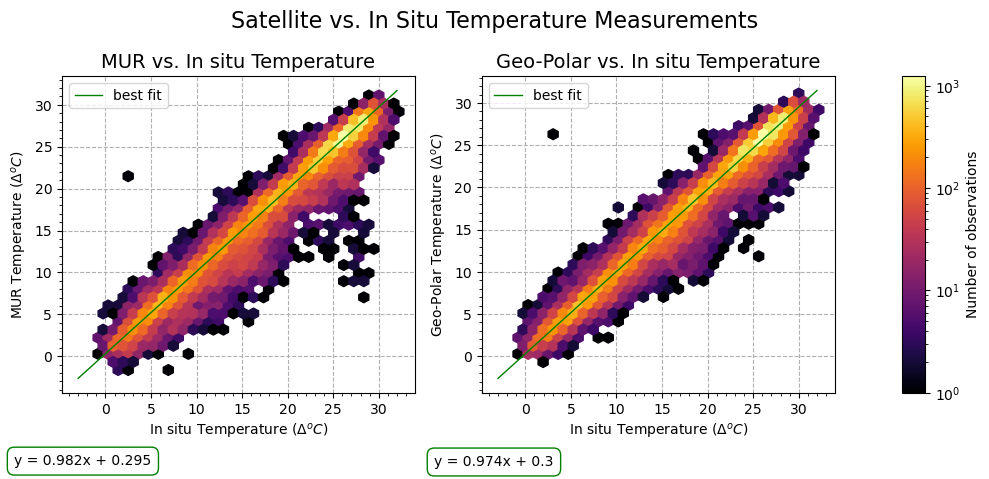

In [26]:
gridspec = {'width_ratios': [1.5, 1.5, 0.1]}
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw=gridspec)
fig.suptitle('Satellite vs. In Situ Temperature Measurements', size=16)

bbox_props = {'boxstyle': 'round', 'facecolor': 'white',
             'pad': 0.5, 'edgecolor': 'green'}

# my_cmap = matplotlib.cm.get_cmap('magma_r')
# my_cmap.set_under('w')

# gridsize used to be 30, 30
mur_plot = ax1.hexbin(x_mur, y_mur, gridsize=30, bins='log', cmap='inferno', 
                      extent=(xmin, xmax, ymin, ymax)) # mincnt=1)
# plot the line of linear fit
# ax1.plot([-8, 8], [mx_plus_b(-8, mur_slope, mur_intercept), 
#                      mx_plus_b(8, mur_slope, mur_intercept)], 
#          color='green', label='linear fit', linewidth=0.8)
ax1.plot([-3, 32], [mx_plus_b(-3, rlm_slope_mur, rlm_inter_mur), 
                     mx_plus_b(32, rlm_slope_mur, rlm_inter_mur)], 
         color='green', label='best fit', linewidth=1)
ax1.set_ylabel('MUR Temperature ($\Delta^oC$)')
ax1.set_title('MUR vs. In situ Temperature', size=14)
ax1.text(-10, -13, 'y = {m}x + {b}'.format(m=rlm_slope_mur.round(3), 
                                    b=rlm_inter_mur.round(3)), bbox=bbox_props)


geop_plot = ax2.hexbin(x_geop, y_geop, gridsize=30, bins='log', cmap='inferno',
                      extent=(xmin, xmax, ymin, ymax))  # , mincnt=1)
# plot the line of linear fit
# ax2.plot([-8, 8], [mx_plus_b(-8, gp_slope, gp_intercept), 
#                      mx_plus_b(8, gp_slope, gp_intercept)], 
#          color='green', label='linear fit', linewidth=0.8)
ax2.plot([-3, 32], [mx_plus_b(-3, rlm_slope_geop, rlm_inter_geop), 
                     mx_plus_b(32, rlm_slope_geop, rlm_inter_geop)], 
         color='green', label='best fit', linewidth=1)
ax2.set_ylabel('Geo-Polar Temperature ($\Delta^oC$)')
ax2.set_title('Geo-Polar vs. In situ Temperature', size=14)
ax2.text(-10, -13, 'y = {m}x + {b}'.format(m=rlm_slope_geop.round(3), 
                                    b=rlm_inter_geop.round(3)), bbox=bbox_props)


# Standardize axes settings
for ax in (ax1, ax2):
    # plot and label the 1:1 line
    # ax.plot([-10, 10], [-10, 10], color='blue', label='1:1 line', linewidth=0.8)
    ax.legend(loc="upper left")
    # standardize the axes
    # ax.set_xlim([-16, 16])
    # ax.set_ylim([-12, 8])
    # label the x axis
    ax.set_xlabel('In situ Temperature ($\Delta^oC$)')
    ax.minorticks_on()
    # add gridlines
    ax.set_axisbelow(True)
    ax.grid(linestyle='--', linewidth=0.8)

# Add shared colorbar
cb = fig.colorbar(geop_plot, cax=ax3)
cb.set_label('Number of observations')

# Turn back on for SST Values
fig.tight_layout()

if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures/validation_analysis/satellite_validation_raw_hexplot.jpeg'), 
                bbox_inches='tight', dpi=700)


### Preprocessing

In [35]:
wq_sst['geopolar_diff'] = wq_sst['geopolar'] - wq_sst['MeasureValue']
wq_sst['mur_diff'] = wq_sst['mur'] - wq_sst['MeasureValue']

In [36]:
temps_mean = wq_sst.groupby(['Latitude', 'Longitude']).mean()
temps_mean = temps_mean.reset_index()

/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_3245/1720388.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps_mean = wq_sst.groupby(['Latitude', 'Longitude']).mean()


## RMSE

In [37]:
N = len(wq_sst[~wq_sst['geopolar_diff'].isnull()])

rmse_geopolar = np.sqrt((wq_sst['geopolar_diff']**2).sum() / N)
print('rmse geopolar: ', rmse_geopolar)

N = len(wq_sst[~wq_sst['mur_diff'].isnull()])

rmse_mur = np.sqrt((wq_sst['mur_diff']**2).sum() / N)
print('rmse mur: ', rmse_mur)

rmse geopolar:  1.5629639137336624
rmse mur:  1.8112693194027103


## Error Histogram

**TODO:** What is the point of the plot? Is it to show that the distribtuion is just a bit wider/narrow in each satellite? Or is it to show that one outlier?

In [38]:
wq_sst_mur = wq_sst[~wq_sst.mur_diff.isnull()]
wq_sst_gp = wq_sst[~wq_sst.geopolar_diff.isnull()]

In [39]:
mur_mean, mur_std = wq_sst_mur.mur_diff.mean(), wq_sst_mur.mur_diff.std()
gp_mean, gp_std = wq_sst_gp.geopolar_diff.mean(), wq_sst_gp.geopolar_diff.std()

In [40]:
mur_skew, mur_kurtosis = scipy.stats.skew(wq_sst_mur.mur_diff), scipy.stats.kurtosis(wq_sst_mur.mur_diff)
gp_skew, gp_kurtosis = scipy.stats.skew(wq_sst_gp.geopolar_diff), scipy.stats.kurtosis(wq_sst_gp.geopolar_diff)

In [41]:
print('mur skew / kurtosis: ', mur_skew, mur_kurtosis)
print('geopolar skew / kurtosis: ', gp_skew, gp_kurtosis)

mur skew / kurtosis:  -1.880341587677962 10.13949413757137
geopolar skew / kurtosis:  -1.0408460932054557 6.879465342358197


In [42]:
mur_mean, mur_std

(-0.39130512331257516, 1.7685256176391038)

In [43]:
gp_mean, gp_std

(-0.37111893989183925, 1.5182878109568065)

**TODO** Can I justify this times 2000 thing?

In [44]:
# Normal Distributions
x_norm = np.linspace(-10, 10, 100)
mur_norm = [stats.norm.pdf(x, mur_mean, mur_std)*2000 for x in x_norm]
gp_norm = [stats.norm.pdf(x, gp_mean, gp_std)*2000 for x in x_norm]
# stats.norm.pdf(x, mu, sigma)

In [45]:
# fig, (ax1, ax2) = plt.subplots(1, 2)

# fig.set_size_inches(8, 3)
# fig.suptitle('Histogram of SST Anomaly for MUR and Geopolar Blended')

# wq_sst_mur.geopolar_diff.hist(ax = ax2, bins=75)
# ax2.set_title('mur value' + ' Histogram')
# # Plot normal curve
# ax2.plot(x_norm, gp_norm, linewidth=0.8)
# ax2.set_yscale('log')

# wq_sst_gp.mur_diff.hist(ax = ax1, bins=75, log=True)
# ax1.set_title('geopolar value' + ' Histogram')
# ax1.set_ylabel('Count')
# ax1.plot(x_norm, mur_norm, linewidth=0.8)
# ax1.set_yscale('log')

# for ax in (ax1, ax2):
#     # label x axis
#     ax.set_xlabel('Temperature Error ($^oC$)')
#     # standardize axes
#     # ax.set_xlim([-8, 23])
#     ax.set_ylim([0.9, 1000])
#     ax.set_xlim([-20, 26])
#     # ax.set_ylim([0.8, 10000])
#     # WHAT TO DO ABOUT GRIDLINES
#     # add minor ticks
#     # ax.xaxis.grid(which='major', color='#DDDDDD', linewidth=0.8)
#     # # Show the minor grid as well. Style it in very light gray as a thin,
#     # # dotted line.
#     ax.xaxis.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
#     ax.xaxis.set_minor_locator(AutoMinorLocator())
#     ax.grid(False)
#     # ax.axvline(0, color='black')

# plt.tight_layout()
# if SAVE_FIGS:
#     plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/errors_histogram.png'), 
#                 dpi=400, bbox_inches='tight')

## Spatial Plots

**TODO**: figure out if there is a way to improve the resolution of the coastline, so it doesn't look like there are datapoints being taken on land.

**TODO**: Awkward spacing

In [46]:
temps_mean_gpd = gpd.GeoDataFrame(
    temps_mean, geometry=gpd.points_from_xy(temps_mean['Longitude'], temps_mean['Latitude']), 
    crs='epsg:4326'
)

Below: There are 49 anomaly validation stations spread across the bay

In [43]:
# temps_mean_gpd.groupby(['Latitude', 'Longitude']).groups

<AxesSubplot: >

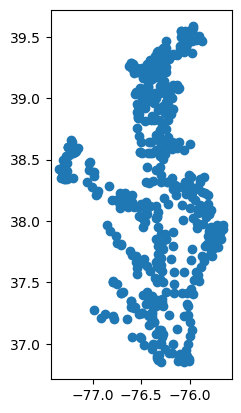

In [44]:
temps_mean_gpd.plot()

### Long Term Trend by location

In [45]:
wq_sst.SampleDate

0       2007-03-22
1       2007-06-18
2       2007-10-29
3       2007-12-10
4       2008-02-04
           ...    
35723   2008-07-22
35724   2008-08-22
35725   2008-09-17
35726   2008-10-16
35727   2008-11-20
Name: SampleDate, Length: 35728, dtype: datetime64[ns]

In [46]:
def get_slope(df):
    '''
    Slope of the long term trend in geopolar error.
    Units unknown a.t.m.
    '''
    # print(len(df))
    x = df.SampleDate.apply(lambda x: x.toordinal())
    y = df.geopolar_diff
    # Slope of long term trend
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    # Multiply by 365 so units are degrees / year not degrees / day
    df['slope'] = slope * 365
    if p_value >= 0.05:
        df['slope'] = np.nan
    # Mean
    df['mean'] = df.geopolar_diff.mean()
    # STD
    df['std'] = df.geopolar_diff.std()
    # Skew
    df['skew'] = scipy.stats.skew(df.geopolar_diff)
    # kurtosis
    df['kurt'] = scipy.stats.kurtosis(df.geopolar_diff)
    # 95th percentile
    df['95th'] = df.geopolar_diff.quantile(0.95)
    return df

In [47]:
slopes = wq_sst.groupby(['Latitude', 'Longitude'], group_keys=True).apply(get_slope)

/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/rwegener/miniconda3/envs/chesapeake_mhw/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_2795/377247510.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  df['skew'] = scipy.stats.skew(df.geopolar_diff)
/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm

In [48]:
slopes

MeasureValue  Latitude  Longitude SampleDate  \
Latitude Longitude                                                       
36.84833 -76.29806 14423          17.9  36.84833  -76.29806 2007-05-01   
                   14424          20.0  36.84833  -76.29806 2007-05-23   
                   14425          24.2  36.84833  -76.29806 2007-06-13   
                   14426          27.7  36.84833  -76.29806 2007-07-18   
                   14427          28.4  36.84833  -76.29806 2007-08-15   
...                                ...       ...        ...        ...   
39.58310 -75.96380 34806          24.5  39.58310  -75.96380 2009-09-03   
                   34807          20.1  39.58310  -75.96380 2009-09-17   
                   34808          18.2  39.58310  -75.96380 2009-10-01   
                   34809          17.4  39.58310  -75.96380 2009-10-06   
                   34810          14.4  39.58310  -75.96380 2009-10-15   

                           geopolar        mur  geopolar_diff  mur_diff  \
Latitude Longitude                                                        
36.84833 -76.29806 14423        NaN  16.708008            NaN -1.191992   
                   14424        NaN  19.148987            NaN -0.851013   
                   14425        NaN  22.919983            NaN -1.280017   
                   14426        NaN  27.908997            NaN  0.208997   
                   14427        NaN  27.572998            NaN -0.827002   
...                             ...        ...            ...       ...   
39.58310 -75.96380 34806  23.979980  26.014984      -0.520020  1.514984   
                   34807  22.139984  21.945007       2.039984  1.845007   
                   34808  19.739990  20.505005       1.539990  2.305005   
                   34809  18.829987  19.065979       1.429987  1.665979   
                   34810  17.459991  17.169006       3.059991  2.769006   

                             slope     mean      std      skew      kurt  \
Latitude Longitude                                                         
36.84833 -76.29806 14423       NaN      NaN      NaN       NaN       NaN   
                   14424       NaN      NaN      NaN       NaN       NaN   
                   14425       NaN      NaN      NaN       NaN       NaN   
                   14426       NaN      NaN      NaN       NaN       NaN   
                   14427       NaN      NaN      NaN       NaN       NaN   
...                            ...      ...      ...       ...       ...   
39.58310 -75.96380 34806  1.253146 -2.44092  2.88706  0.076858 -0.583006   
                   34807  1.253146 -2.44092  2.88706  0.076858 -0.583006   
                   34808  1.253146 -2.44092  2.88706  0.076858 -0.583006   
                   34809  1.253146 -2.44092  2.88706  0.076858 -0.583006   
                   34810  1.253146 -2.44092  2.88706  0.076858 -0.583006   

                              95th  
Latitude Longitude                  
36.84833 -76.29806 14423       NaN  
                   14424       NaN  
                   14425       NaN  
                   14426       NaN  
                   14427       NaN  
...                            ...  
39.58310 -75.96380 34806  2.365992  
                   34807  2.365992  
                   34808  2.365992  
                   34809  2.365992  
                   34810  2.365992  

[35728 rows x 14 columns]

In [49]:
stats_gpd = gpd.GeoDataFrame(
    slopes, geometry=gpd.points_from_xy(slopes.Longitude, slopes.Latitude), crs="EPSG:4326"
)

In [50]:
std = wq_sst.groupby(['Latitude', 'Longitude', wq_sst.SampleDate.dt.month]).std(numeric_only=True) \
.groupby(['Latitude', 'Longitude']).mean().reset_index()

In [51]:
std_gpd = gpd.GeoDataFrame(
    std, geometry=gpd.points_from_xy(std.Longitude, std.Latitude), crs="EPSG:4326"
)

In [52]:
print('Geopolar max/min:', temps_mean_gpd.geopolar_diff.max(), temps_mean_gpd.geopolar_diff.min(), 
     temps_mean_gpd.geopolar_diff.median(), temps_mean_gpd.geopolar_diff.std())
# print('MUR max/min:', temps_mean_gpd.mur_diff.max(), temps_mean_gpd.mur_diff.min(),
#      temps_mean_gpd.mur_diff.median(), temps_mean_gpd.mur_diff.std())

Geopolar max/min: 3.069982910156251 -5.091006469726564 -0.5726563038545498 0.9603613675457604


In [53]:
vmin, vmax = -1, 1

In [54]:
norm = matplotlib.colors.SymLogNorm(linthresh=1, vmin=-5, vmax=5, base=10)

<AxesSubplot: >

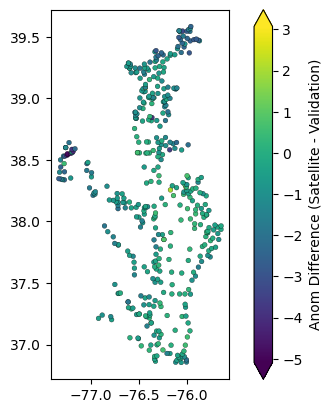

In [55]:
temps_mean_gpd.plot(column='geopolar_diff', markersize=12, legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 'extend': 'both'}, 
                    edgecolor='black', linewidth=0.2)

In [56]:
temps_mean_gpd.geopolar_diff.max()

3.069982910156251

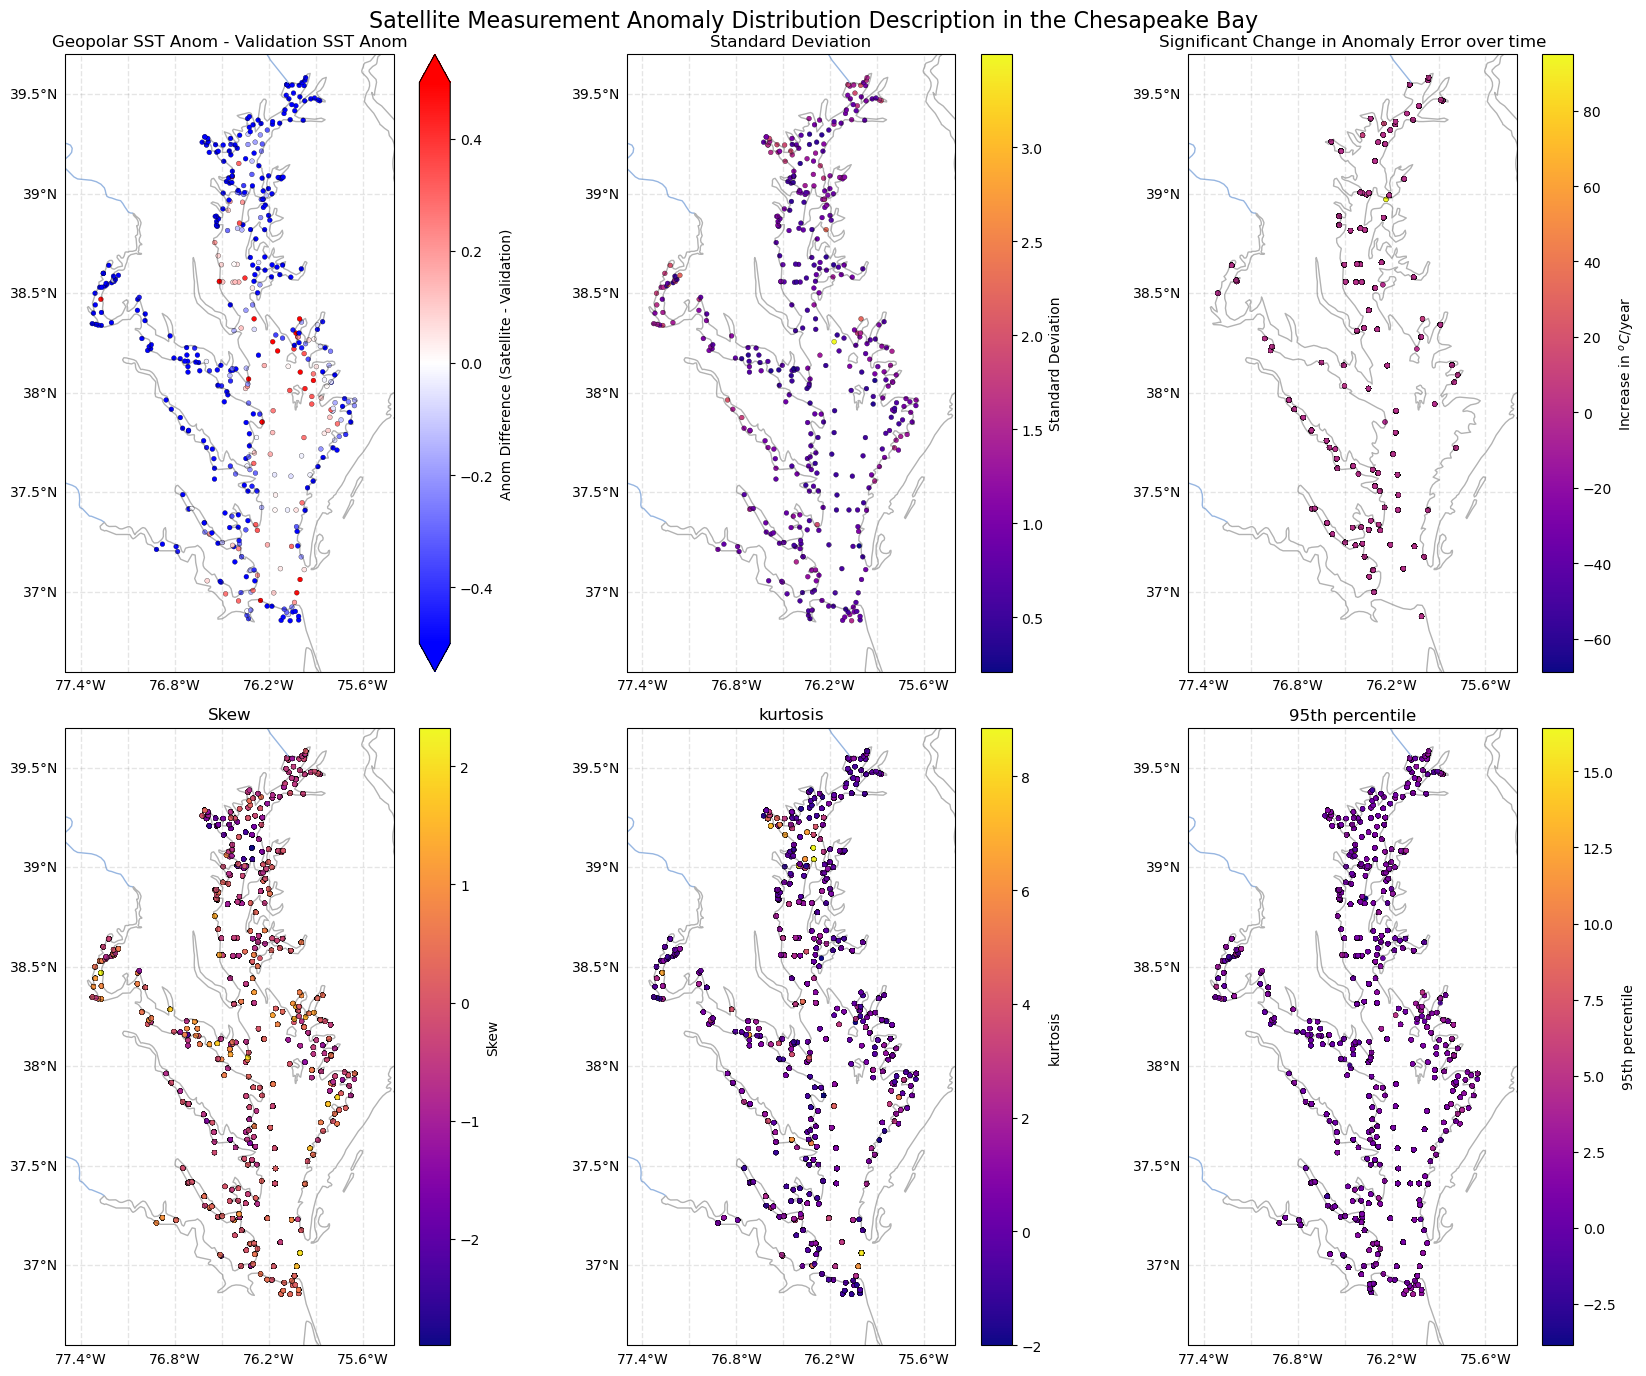

In [57]:
fig, axes = plt.subplots(2, 3, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(17, 14)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Anomaly Distribution Description in the Chesapeake Bay', size=16)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# Add mean error
temps_mean_gpd.plot(ax=axes[0, 0], column='geopolar_diff', markersize=12, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 'extend': 'both'}, 
                    vmin=-0.5, vmax=0.5, edgecolor='black', linewidth=0.2)
axes[0, 0].set_title('Geopolar SST Anom - Validation SST Anom', size=12)

# Standard Deviation
std_gpd.plot(ax=axes[0, 1], column='geopolar_diff', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Standard Deviation"}, 
                    edgecolor='black', linewidth=0.2)
axes[0, 1].set_title('Standard Deviation', size=12)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=axes[0, 2], column='slope', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Increase in $^oC$/year"}, 
                    edgecolor='black', linewidth=0.2)
axes[0, 2].set_title('Significant Change in Anomaly Error over time', size=12)


# Skew
stats_gpd.plot(ax=axes[1, 0], column='skew', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Skew"}, 
                    edgecolor='black', linewidth=0.2)
axes[1, 0].set_title('Skew', size=12)

# Kurtosis
stats_gpd.plot(ax=axes[1, 1], column='kurt', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "kurtosis"}, 
                    edgecolor='black', linewidth=0.2)
axes[1, 1].set_title('kurtosis', size=12)

# 95th Percentile
stats_gpd.plot(ax=axes[1, 2], column='95th', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "95th percentile"}, 
                    edgecolor='black', linewidth=0.2)
axes[1, 2].set_title('95th percentile', size=12)


plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/map_distribution_statistics.png'), 
                dpi=400, bbox_inches='tight')

Significant Time increases by spatial location

In [58]:
def trend_calc(df):
    '''
    When grouping by lat/long aggregate the anomalies by sorting in time and calculating
    returning True/False based on if there is a statistically significant change in 
    MeasureAnomaly over time
    '''
    df = df.sort_values('SampleDate')
    df = df[~df.geopolar_diff.isnull()]
    # print('IS NULL?', df.SampleDate.apply(lambda x: x.toordinal()))
    x = df.SampleDate.apply(lambda x: x.toordinal())
    y = df.geopolar_diff.values
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print(slope, intercept, r_value, p_value, std_err)
    plt.plot(x, y)
    plt.show()
    return slope

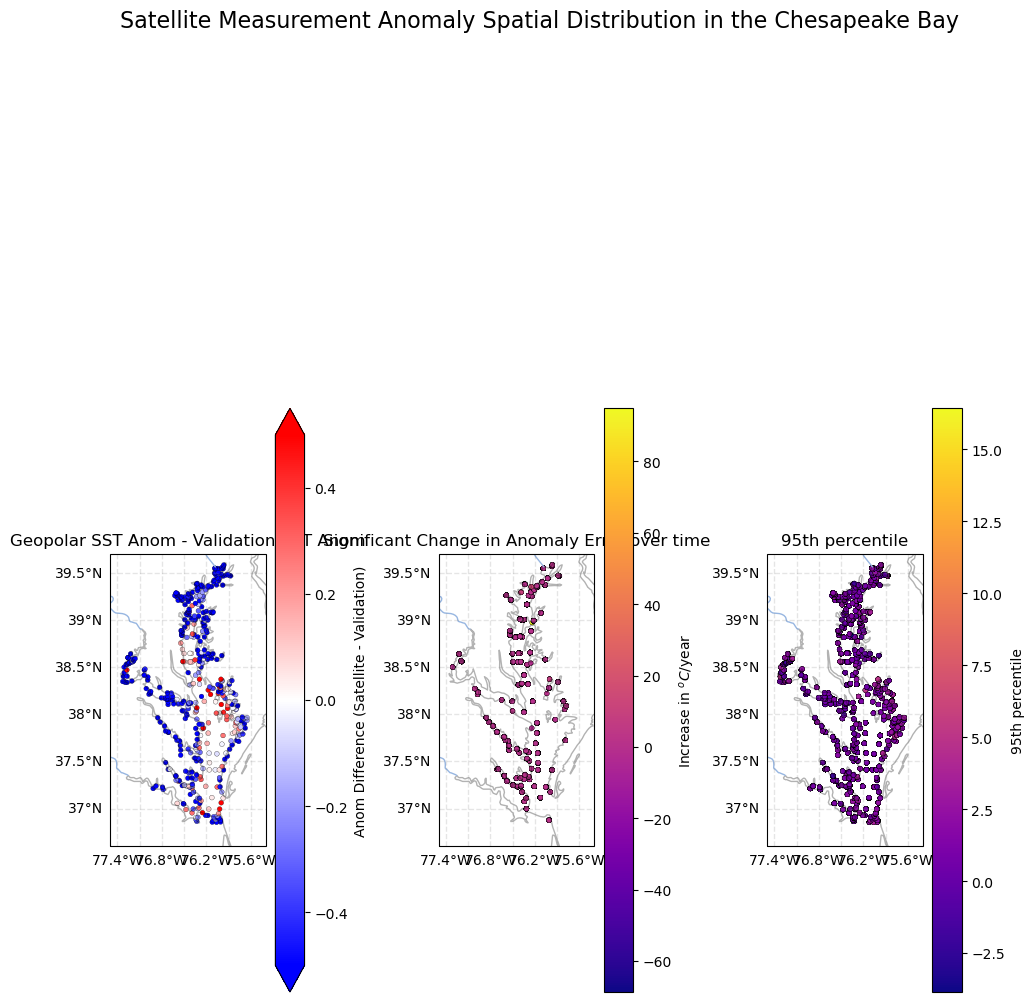

In [59]:
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(10, 14)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Anomaly Spatial Distribution in the Chesapeake Bay', size=16)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    # ax.set_aspecxt('equal', 'box')

# Add mean error
temps_mean_gpd.plot(ax=axes[0], column='geopolar_diff', markersize=12, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 'extend': 'both'}, 
                    vmin=-0.5, vmax=0.5, edgecolor='black', linewidth=0.2)
axes[0].set_title('Geopolar SST Anom - Validation SST Anom', size=12)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=axes[1], column='slope', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Increase in $^oC$/year"}, 
                    edgecolor='black', linewidth=0.2)
axes[1].set_title('Significant Change in Anomaly Error over time', size=12)

# 95th Percentile
stats_gpd.plot(ax=axes[2], column='95th', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "95th percentile"}, 
                    edgecolor='black', linewidth=0.2)
axes[2].set_title('95th percentile', size=12)


plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/map_distribution_statistics.png'), 
                dpi=400, bbox_inches='tight')

In [60]:
print(temps_mean_gpd.geopolar_diff.max())
print(temps_mean_gpd.geopolar_diff.min())
print(temps_mean_gpd.mur_diff.max())
print(temps_mean_gpd.mur_diff.min())

3.069982910156251
-5.091006469726564
3.1144927978515615
-10.552001953125


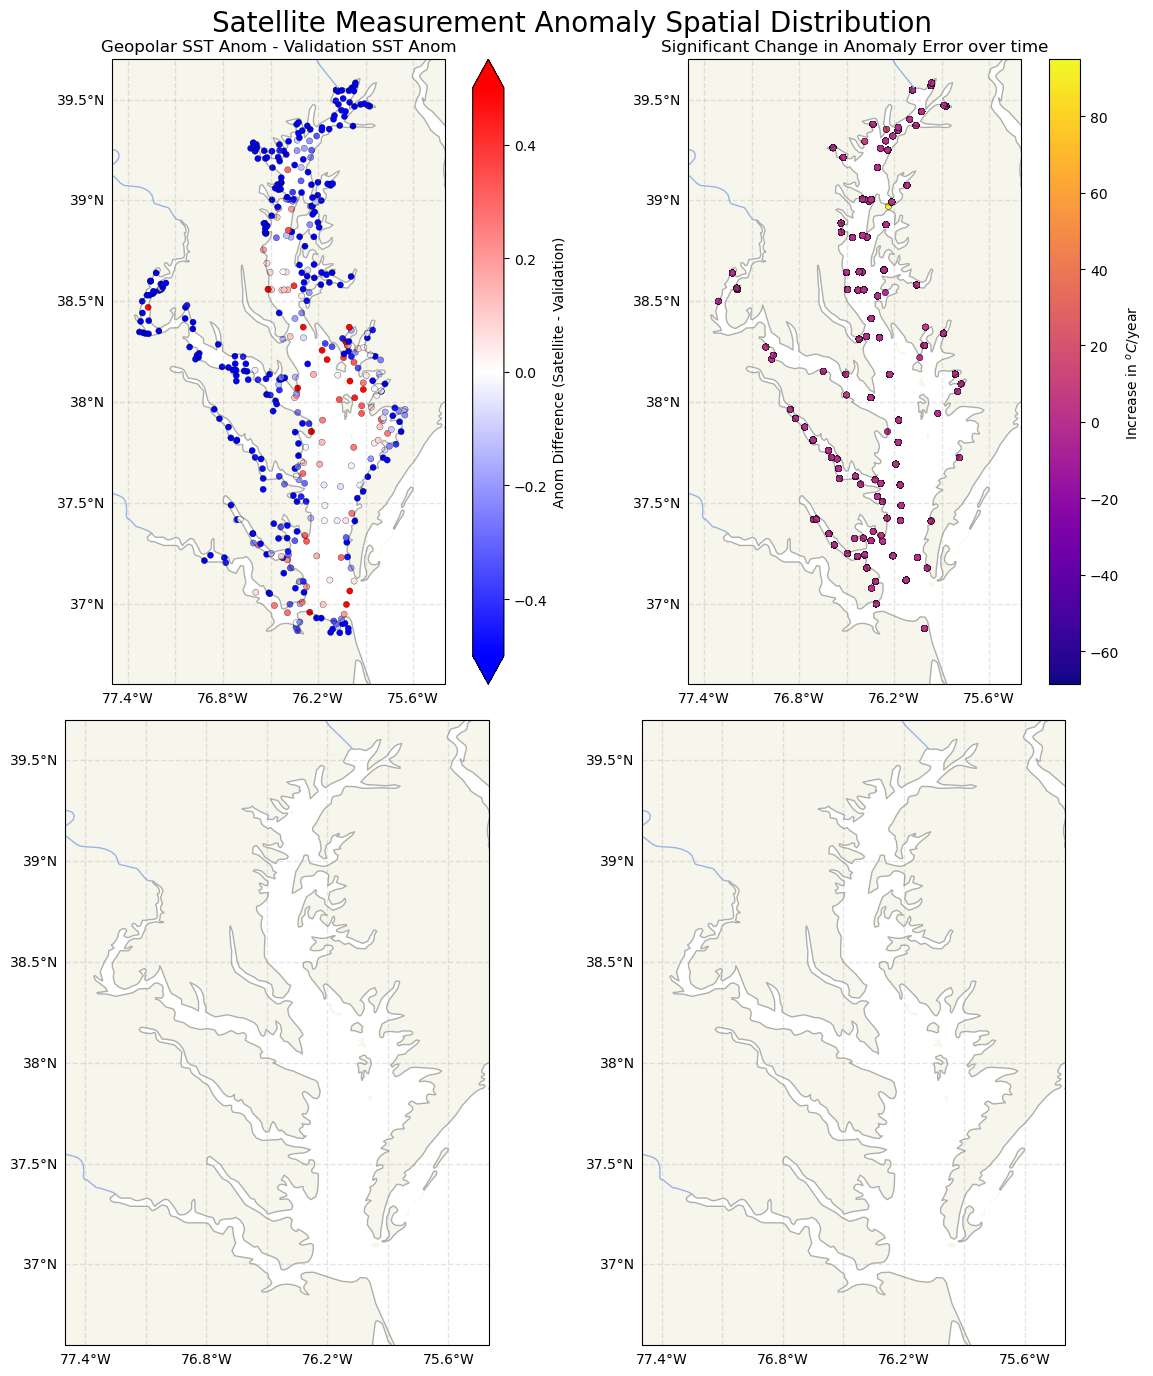

In [61]:
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(12, 14)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Anomaly Spatial Distribution', size=20)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()
    # Put a background image on for nice sea rendering.
    # ax.stock_img()

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# Add mean error
temps_mean_gpd.plot(ax=axes[0, 0], column='geopolar_diff', markersize=20, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 'extend': 'both'}, 
                    vmin=-0.5, vmax=0.5, edgecolor='black', linewidth=0.2)
axes[0, 0].set_title('Geopolar SST Anom - Validation SST Anom', size=12)

# Standard Deviation
# std_gpd.plot(ax=axes[0, 1], column='geopolar_diff', markersize=12, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "Standard Deviation"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[0, 1].set_title('Standard Deviation', size=12)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=axes[0, 1], column='slope', markersize=20, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Increase in $^oC$/year"}, 
                    edgecolor='black', linewidth=0.2)
axes[0, 1].set_title('Significant Change in Anomaly Error over time', size=12)

# Skew
# stats_gpd.plot(ax=axes[1, 0], column='skew', markersize=12, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "Skew"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[1, 0].set_title('Skew', size=12)

# Kurtosis
# stats_gpd.plot(ax=axes[1, 1], column='kurt', markersize=12, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "kurtosis"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[1, 1].set_title('kurtosis', size=12)

# 95th Percentile
# stats_gpd.plot(ax=axes[0, 2], column='95th', markersize=20, cmap='plasma',
#                 legend=True,
#                     legend_kwds={'label': "95th percentile"}, 
#                     edgecolor='black', linewidth=0.2)
# axes[0, 2].set_title('95th percentile', size=12)


plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/map_distribution_statistics_shorter.png'), 
                dpi=400, bbox_inches='tight')

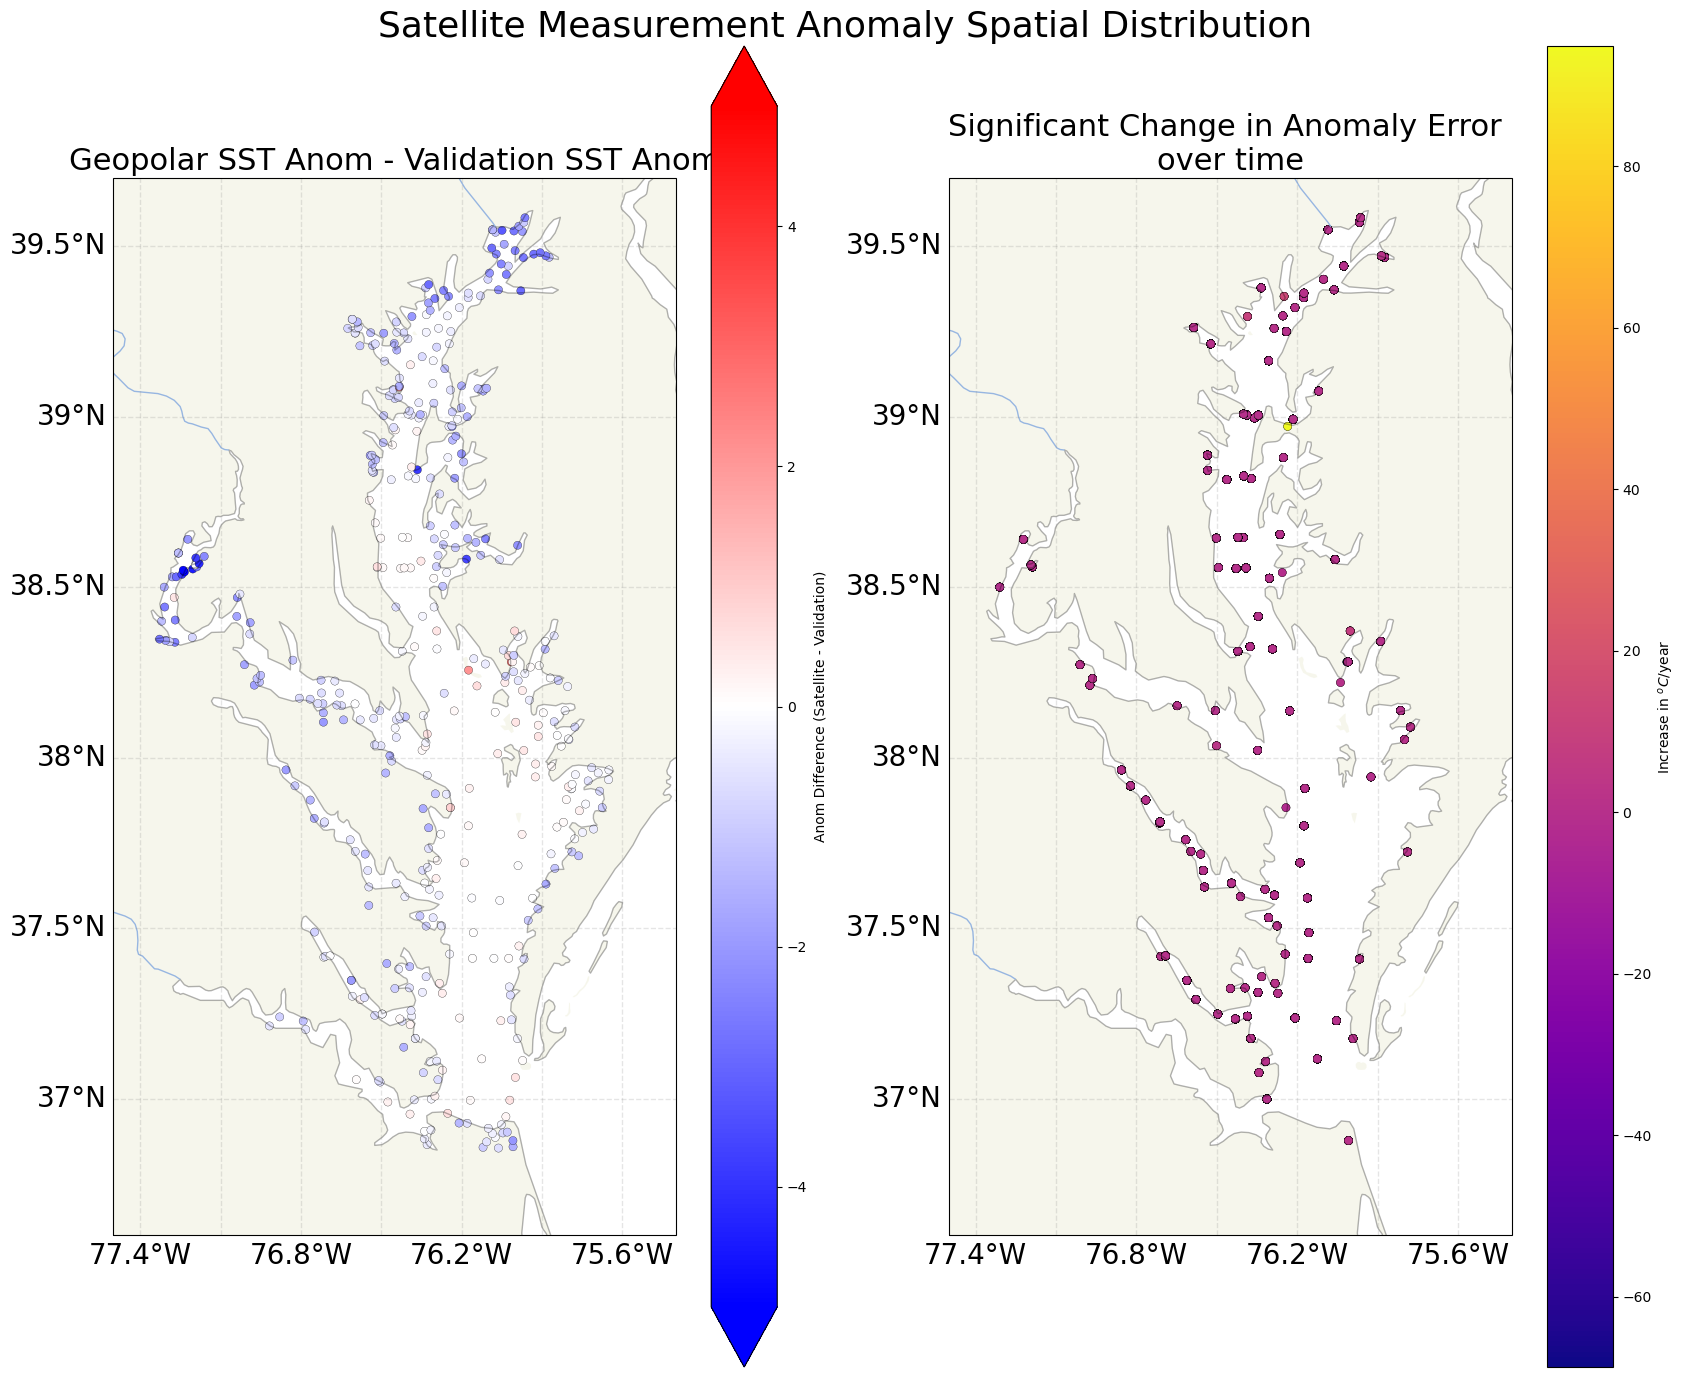

In [62]:
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(17, 14)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Anomaly Spatial Distribution', size=26)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()
    # Put a background image on for nice sea rendering.
    # ax.stock_img()

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}

# Add mean error
temps_mean_gpd.plot(ax=axes[0], column='geopolar_diff', markersize=35, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 
                                 'extend': 'both'}, 
                    vmin=-5, vmax=5, edgecolor='black', linewidth=0.2)
axes[0].set_title('Geopolar SST Anom - Validation SST Anom', size=22)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=axes[1], column='slope', markersize=35, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Increase in $^oC$/year"}, 
                    edgecolor='black', linewidth=0.2)
axes[1].set_title('Significant Change in Anomaly Error \nover time', size=22)

plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/map_distribution_statistics_shorter.png'), 
                dpi=400, bbox_inches='tight')

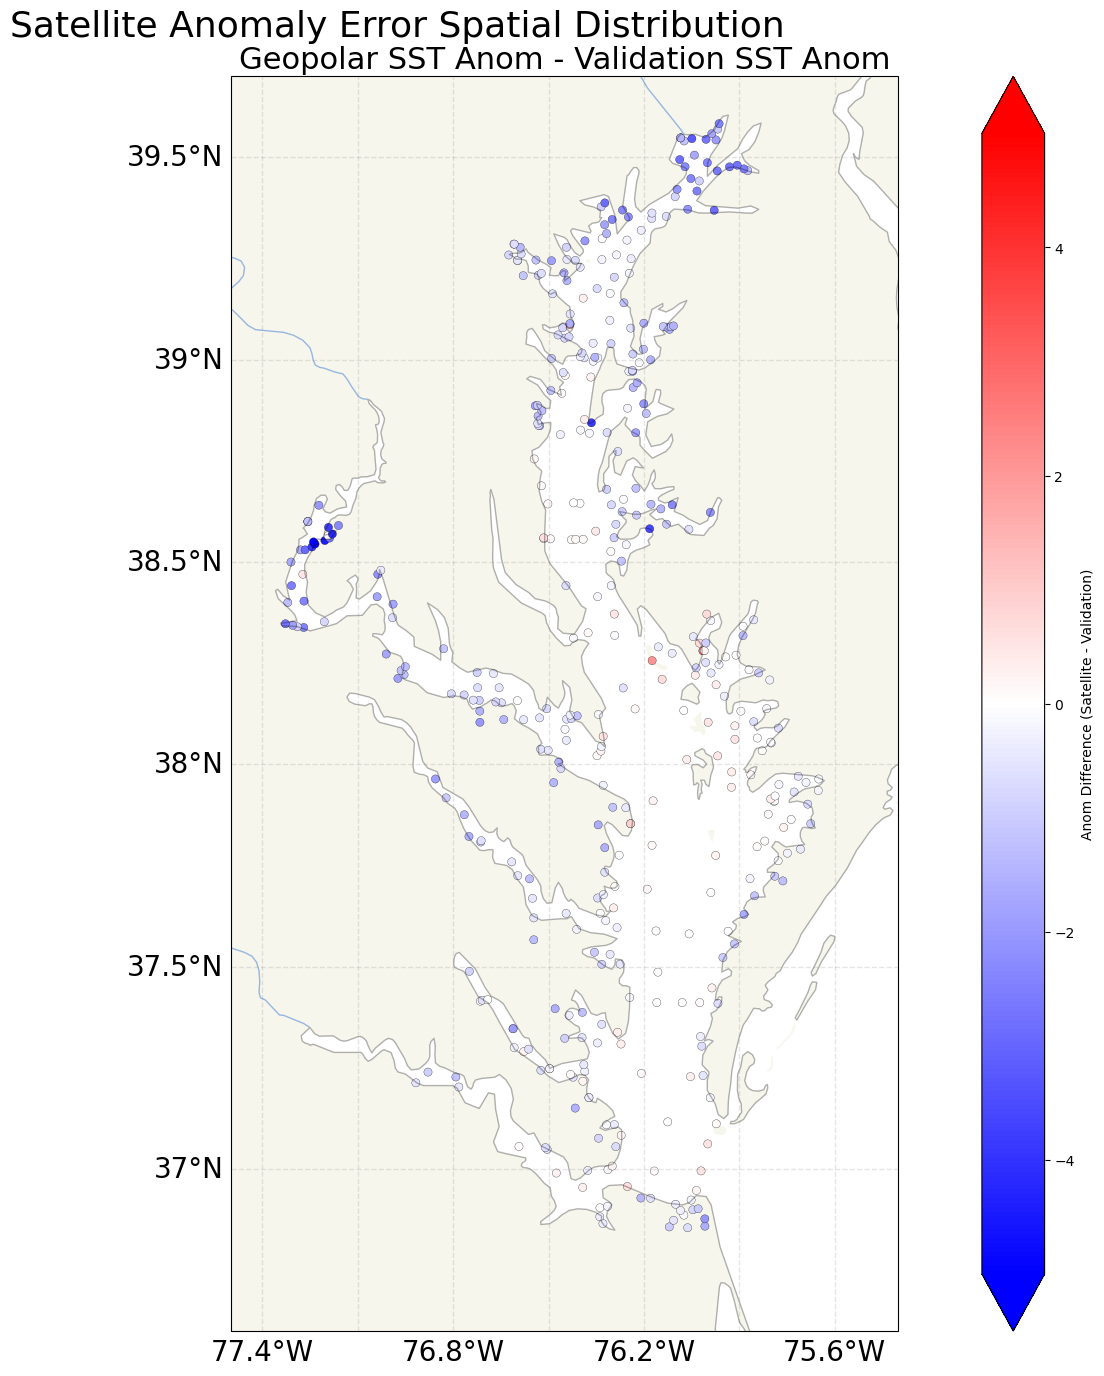

In [63]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(17, 14)
# fig.tight_layout()
fig.suptitle('Satellite Anomaly Error Spatial Distribution', size=26)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

# Add background features
ax.add_feature(cfeature.COASTLINE, alpha=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
# ax.coastlines()
# Put a background image on for nice sea rendering.
# ax.stock_img()

ax.set_extent([-77.5, -75.4, 36.6, 39.7])

# Add and format gridlines. Remove top and right labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.top_labels, gl.right_labels = False, False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add mean error
temps_mean_gpd.plot(ax=ax, column='geopolar_diff', markersize=35, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 
                                 'extend': 'both'}, 
                    vmin=-5, vmax=5, edgecolor='black', linewidth=0.2)
ax.set_title('Geopolar SST Anom - Validation SST Anom', size=22)


plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/map_distribution_statistics_shorter.png'), 
                dpi=400, bbox_inches='tight')

In [64]:
# SAVE_FIGS = True

In [65]:
temps_mean_gpd.mur_diff.min()

-10.552001953125

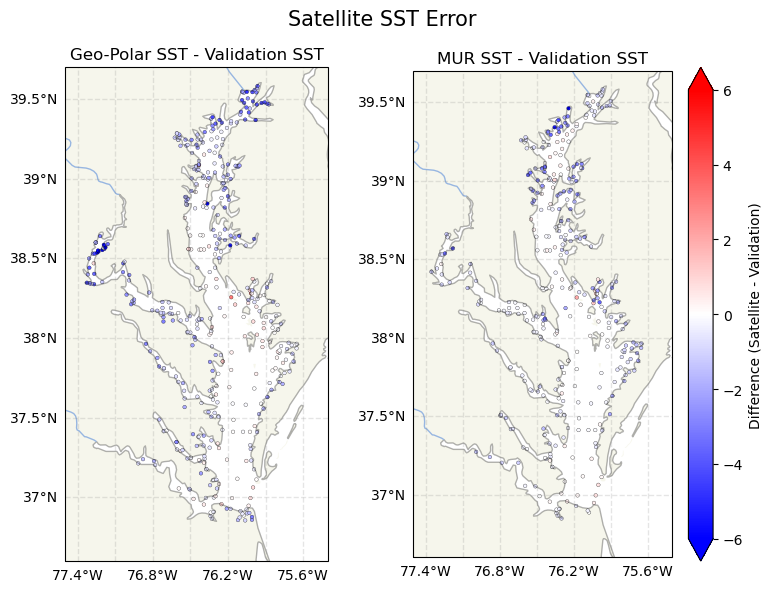

In [66]:
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(8, 6)
# fig.tight_layout()
# plt.title('Satellite Anomaly Error Spatial Distribution', size=15)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes:
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()
    # Put a background image on for nice sea rendering.
    # ax.stock_img()
    
    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

# Add mean error
temps_mean_gpd.plot(ax=axes[0], column='geopolar_diff', markersize=7, cmap='bwr', # legend=True, 
                    # legend_kwds={'label': "Difference (Satellite - Validation)", 
                    #              'extend': 'both'}, 
                    vmin=-4, vmax=4, edgecolor='black', linewidth=0.2)
axes[0].set_title('Geo-Polar SST - Validation SST', size=12)

# Add mean error
temps_mean_gpd.plot(ax=axes[1], column='mur_diff', markersize=7, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Difference (Satellite - Validation)", 
                                 'extend': 'both'}, 
                    vmin=-6, vmax=6, edgecolor='black', linewidth=0.2)
axes[1].set_title('MUR SST - Validation SST', size=12)

fig.suptitle('Satellite SST Error', size=15, ha='center')

plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/raw_sst_error_spatial_distribution.png'), 
                dpi=700, bbox_inches='tight')

Walking through p values:

Question: Does the size of the anomaly value vary over time?
Hypothesis: ...

In [67]:
# wq_sst.groupby(['Latitude', 'Longitude']).apply(trend_calc)

## Hovm&#246;ller Plot for Seasonality of Error



In [68]:
def create_hovmoller_matrix(temps, satellite):
    temps = temps.set_index(pd.to_datetime(temps['SampleDate']))
    temps = temps.resample('M').mean()
    
    temps = temps[[satellite + '_diff']]
    
    temps['month'] = temps.index.month
    temps['year'] = temps.index.year
    
    matrix = temps.pivot(index='year', columns='month')
    
    # print(satellite, 'min / max', satellite, ':', matrix.min().min(), matrix.max().max())
    # print(satellite, 'mean / std', satellite, ':', matrix.mean().mean(), matrix.std().std())
    return matrix

In [69]:
wq_sst_gp[(wq_sst_gp.SampleDate.dt.month == 4) & (wq_sst_gp.SampleDate.dt.year == 2020)]

,MeasureValue,Latitude,Longitude,SampleDate,geopolar,mur,geopolar_diff,mur_diff
432,17.550000,36.90210,-76.02970,2020-04-09,13.559998,NaN,-3.990002,NaN
439,12.665000,36.89964,-76.04625,2020-04-01,11.259979,NaN,-1.405021,NaN
440,17.440000,36.89964,-76.04625,2020-04-09,13.649994,NaN,-3.790006,NaN
11167,14.044000,37.08370,-76.27150,2020-04-07,13.309998,13.024994,-0.734002,-1.019006
11453,13.096667,37.00755,-76.29974,2020-04-07,13.389984,13.259979,0.293317,0.163313
11496,13.770000,36.95707,-76.25215,2020-04-07,13.449982,13.201996,-0.320018,-0.568004
12098,14.410000,36.88651,-76.07460,2020-04-09,13.910004,13.487000,-0.499996,-0.923000
17506,12.205714,36.92799,-76.17940,2020-04-01,11.779999,12.200989,-0.425716,-0.004726
17507,14.705000,36.92799,-76.17940,2020-04-07,13.149994,13.026001,-1.555006,-1.678999
17508,15.556667,36.92799,-76.17940,2020-04-28,14.429993,14.871002,-1.126674,-0.685664


In [70]:
(wq_sst_gp.geopolar_diff.isnull()).sum()

0

In [71]:
matrix_geop = create_hovmoller_matrix(wq_sst_gp, 'geopolar')
matrix_mur = create_hovmoller_matrix(wq_sst_mur, 'mur')

/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_2795/64737636.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps = temps.resample('M').mean()
/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_2795/64737636.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps = temps.resample('M').mean()


In [72]:
matrix_geop

geopolar_diff                                                    \
month            1         2         3         4         5         6    
year                                                                    
2003       0.653771  0.497163 -0.350406 -0.975392 -1.982545 -1.308672   
2004       0.923054  0.174458 -0.685073 -0.999043 -3.578098 -1.433535   
2005      -0.702444 -0.549184 -0.349128 -1.237926 -1.709731 -1.973950   
2006      -0.350900 -0.420801 -1.000125 -1.539716 -1.751561 -1.887739   
2007      -0.140472  0.282273 -1.618206 -1.109154 -2.845692 -1.950636   
2008      -0.138114 -0.836043 -1.671150 -1.350094 -2.209456 -1.312796   
2009       0.216390 -0.431374 -0.474408 -0.834744 -2.193697 -1.461548   
2010       0.896626  0.538803 -1.654068 -1.570129 -2.869432 -2.193986   
2011       1.391951  0.624930 -0.962114 -1.208658 -1.095392 -0.615997   
2012      -0.076912  0.068628 -0.299720 -0.561257 -1.297014 -0.189611   
2013      -0.243595 -0.208455  0.009084 -0.967782 -0.567473 -0.347688   
2014      -0.133455  0.175500  0.375651 -0.885079 -0.614369 -0.357824   
2015       0.312735 -0.087701 -0.080349 -0.751967 -1.227828 -0.632317   
2016       0.269236 -0.300408 -0.586439 -0.624878 -0.564715 -0.341695   
2017      -0.200703  0.035826 -0.471463 -0.686379 -0.494753 -0.075344   
2018      -0.194068 -0.549572  0.023270 -0.496635 -0.436807  0.292147   
2019       0.405502 -0.222124 -0.524852 -0.346456  0.068749  0.324147   
2020      -1.029006 -0.548502 -0.865390 -1.933896 -0.355679  0.112789   
2021      -0.048160  0.035018 -0.201696  0.196929 -0.119743  0.025526   
2022       0.556066 -0.201291  0.117098 -0.340946  0.231565  0.071365   

                                                                   
month        7         8         9         10        11        12  
year                                                               
2003  -1.321653 -0.750983 -0.552978  0.843662  0.616551  0.844915  
2004  -0.711155 -0.721428  0.007822  0.547090  0.664839  0.166976  
2005  -1.525729 -0.731671 -0.729355  0.841897  0.103299  1.609392  
2006  -1.360048 -1.237369 -0.249806  0.562881  0.029029  1.188659  
2007  -1.528226 -0.753587 -0.389899 -0.062752  1.303839  1.635125  
2008  -0.912997 -0.364566 -0.357225  0.012055  1.087818  0.274387  
2009  -0.470634 -0.708238 -0.175257  1.334707  0.395511  0.607934  
2010  -1.468675 -0.709358 -0.102814  0.294028  0.481552  1.511060  
2011  -0.443943 -0.269404 -0.310086  0.399535  0.337133  0.351000  
2012  -0.347398 -0.130864  0.264600  0.461860  0.768340  0.005695  
2013  -0.080603  0.060875  0.251537  0.036242  1.131937  0.623524  
2014  -0.411534 -0.023571  0.278613  0.330919  1.454980  0.309862  
2015  -0.420487 -0.272309 -0.164519  0.337741  0.252727  0.114776  
2016  -0.278221 -0.055922 -0.129136  0.191247  0.409514  0.688159  
2017  -0.148790 -0.045539 -0.095833  0.589592  0.668046  1.007989  
2018   0.078381  0.041134  0.529795  1.054132  1.038885  0.523482  
2019   0.323653  0.068362  0.175053  0.218146  1.315770  0.267052  
2020   0.010314 -0.010037  0.347844  0.116041  0.419676  0.619398  
2021   0.457620  0.189617  0.102445  0.160480  0.733830  0.235395  
2022   0.168877  0.311395  0.114046  0.191788  1.167753 -0.065066

### Quantifying Long Term trend by month

In [73]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(20),
                                                                     matrix_geop.mean(axis=1))

print('Geopolar: slope', slope.round(3), 'deg C per year', 'intercept', intercept, 'r squared', r_value**2, 'p_value', p_value)

Geopolar: slope 0.041 deg C per year intercept -0.6049768747510146 r squared 0.6659353578688084 p_value 1.1499917947695823e-05


In [74]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(20),
    matrix_mur.mean(axis=1))

print('MUR: slope', slope.round(3), 'deg C per year', 'intercept', intercept, 'r squared', r_value**2, 'p_value', p_value)

MUR: slope 0.063 deg C per year intercept -0.8531990146923916 r squared 0.5920944421655238 p_value 7.297419456249691e-05


In [75]:
def linearregression(row):
    _, _, r_value, p_value, _ = scipy.stats.linregress(range(20), row)
    row['p_value'] = p_value
    # return pd.DataFrame({'p_value': p_value, 'other': 0})
    return p_value

In [76]:
def significant_slopes(row):
    slope, _, r_value, p_value, _ = scipy.stats.linregress(range(20), row)
    # if p_value > 0.05:
    #     slope = np.nan
    # return pd.DataFrame({'p_value': p_value, 'other': 0})
    return slope

In [77]:
geo_pvals = matrix_geop.apply(linearregression, axis=0)
geo_slope = matrix_geop.apply(significant_slopes, axis=0)

In [78]:
mur_pvals = matrix_mur.apply(linearregression, axis=0)
mur_slope = matrix_mur.apply(significant_slopes, axis=0)

In [79]:
geo_pvals.index = geo_pvals.index.droplevel(0)
mur_pvals.index = mur_pvals.index.droplevel(0)

geo_slope.index = geo_slope.index.droplevel(0)
mur_slope.index = mur_slope.index.droplevel(0)

In [80]:
all_pvals = pd.concat([geo_pvals, mur_pvals], axis=1, keys=['geopolar', 'mur'])
all_slopes = pd.concat([geo_slope, mur_slope], axis=1, keys=['geopolar', 'mur'])

In [81]:
geo_slope = pd.DataFrame(geo_slope)
geo_slope['significant'] = geo_slope > 0.05

In [82]:
geo_slope = geo_slope.rename({0: 'error_slope'}, axis=1)

In [83]:
geo_slope

,error_slope,significant
month,,
1,-0.016449,False
2,-0.013679,False
3,0.041951,False
4,0.042326,False
5,0.156803,True
6,0.122671,True
7,0.093700,True
8,0.062230,True
9,0.037744,False


In [84]:
geo_pvals

month
1     4.766117e-01
2     3.962000e-01
3     6.323508e-02
4     2.274096e-02
5     1.014911e-06
6     1.022042e-06
7     5.866144e-07
8     2.472164e-07
9     6.871329e-04
10    1.880164e-01
11    1.918230e-01
12    3.976645e-02
dtype: float64

### Ploting Temporal Trends

In [85]:
vmin, vmax = -2.5, 2.5
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [86]:
cmap = plt.cm.twilight
norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

In [87]:
# import matplotlib.patches as patches

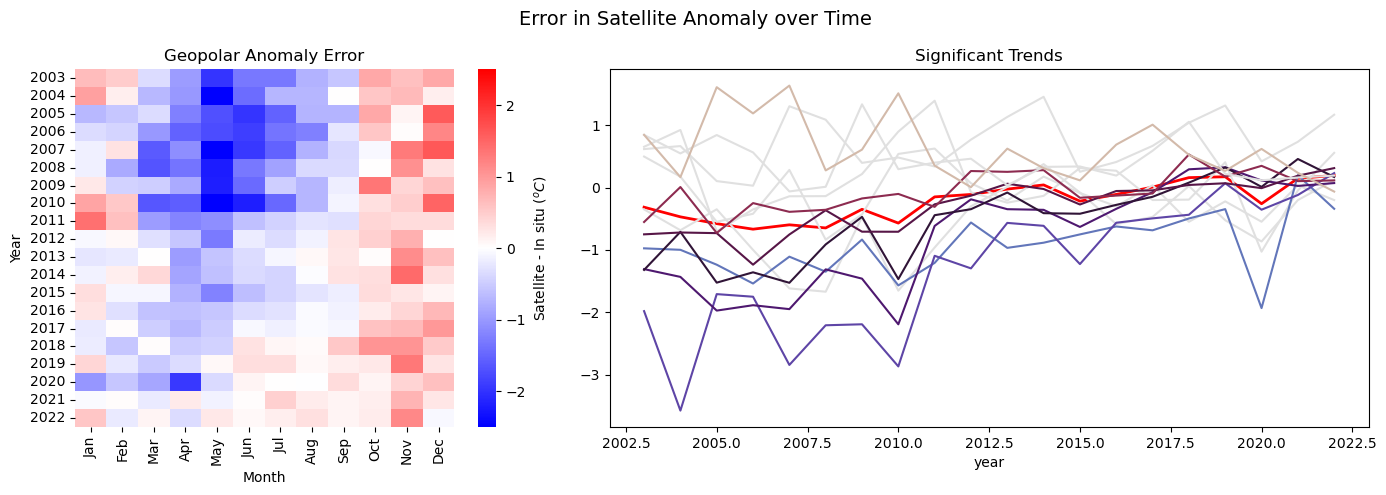

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1.6]})
fig.suptitle('Error in Satellite Anomaly over Time', size=14)

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')

sns.heatmap(matrix_geop, ax=ax1, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite - In situ ($^oC$)'})
ax1.set_xticklabels(months, rotation=90)
ax1.set_xlabel('Month')
ax1.set_ylabel('Year')

# # Create a Rectangle patch
# rect = patches.Rectangle((3, 2021), 40, 1000, linewidth=10, edgecolor='black', facecolor='black')

# # Add the patch to the Axes
# ax1.add_patch(rect)

# Format the colorbar
cmap = plt.cm.twilight
norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
colors=[]
for i in range(12):
    if geo_pvals.iloc[i] > 0.05:
        # append light grey if the trend is not significant
        colors.append((0.878, 0.878, 0.878, 1))
    else:
        colors.append(sm.to_rgba(i+1))

matrix_geop.mean(axis=1).plot(ax=ax2, color='red', linewidth=2, label='mean')
matrix_geop.plot(ax=ax2, color=colors, legend=False)

ax1.set_title('Geopolar Anomaly Error')
ax2.set_title('Significant Trends')


plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/hovmoller_error_withmonths.png'), 
                dpi=350, bbox_inches='tight')

In [89]:
matrix_geop.min().min(), matrix_geop.max().max()

(-3.578098483615452, 1.6351247382886482)

In [97]:
matrix_mur.min().min(), matrix_mur.max().max()

(-6.1529295872490195, 2.7471384684244793)

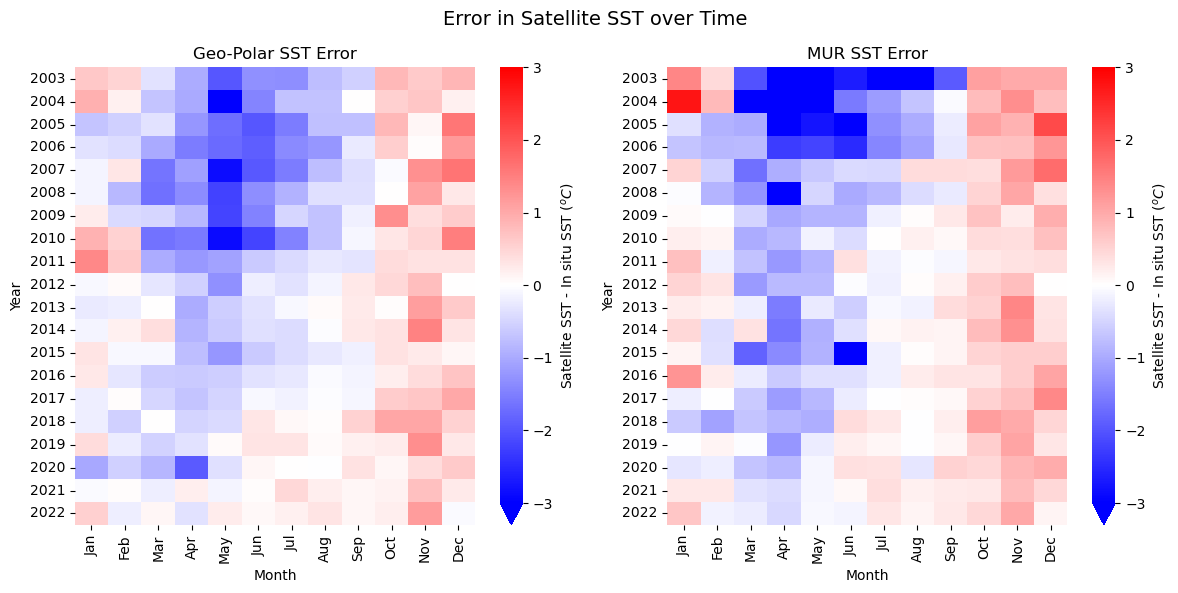

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
fig.suptitle('Error in Satellite SST over Time', size=14)

vmin, vmax = -3, 3

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')

sns.heatmap(matrix_geop, ax=ax1, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite SST - In situ SST ($^oC$)', 'extend': 'min'})
ax1.set_xticklabels(months, rotation=90)
ax1.set_xlabel('Month')
ax1.set_ylabel('Year')
ax1.set_title('Geo-Polar SST Error')

# # Create a Rectangle patch
# rect = patches.Rectangle((3, 2021), 40, 1000, linewidth=10, edgecolor='black', facecolor='black')

# # Add the patch to the Axes
# ax1.add_patch(rect)

# Format the colorbar
# cmap = plt.cm.twilight
# norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
# sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
# colors=[]
# for i in range(12):
#     if geo_pvals.iloc[i] > 0.05:
#         # append light grey if the trend is not significant
#         colors.append((0.878, 0.878, 0.878, 1))
#     else:
#         colors.append(sm.to_rgba(i+1))

sns.heatmap(matrix_mur, ax=ax2, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite SST - In situ SST ($^oC$)', 'extend': 'min'})
ax2.set_xticklabels(months, rotation=90)
ax2.set_xlabel('Month')
ax2.set_ylabel('Year')
ax2.set_title('MUR SST Error')


plt.tight_layout()
SAVE_FIGS = True
if SAVE_FIGS:
    plt.savefig(os.path.join(REPO_ROOT, 'figures/supplemental_material/sst_hovmoller_error.png'), 
                dpi=350, 
                bbox_inches='tight')

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(6, 6)
# fig.suptitle('Error in Satellite Anomaly over Time', size=14)

# bwr_badgrey = plt.cm.get_cmap("bwr").copy()
# bwr_badgrey.set_bad('grey')

# sns.heatmap(matrix_geop, ax=ax, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
#             cbar_kws={'label': 'Satellite Anom - In situ Anom ($^oC$)'})
# ax.set_xticklabels(months, rotation=90)
# ax.set_xlabel('Month')
# ax.set_ylabel('Year')

# matrix_geop.mean(axis=1).plot(ax=ax2, color='red', linewidth=2, label='mean')
# # matrix_geop.plot(ax=ax2, color=colors, legend=False)

# ax1.set_title('Geopolar Anomaly Error')
# # ax2.set_title('Significant Trends')


# plt.tight_layout()
# if SAVE_FIGS:
#     plt.savefig(os.path.join(REPO_ROOT, 'figures/validation_analysis/hovmoller_error.png'), 
#                 dpi=350, 
#                 bbox_inches='tight')